In [ ]:
### 분류용 트랜스포머로 리팽토링 시작

#Tiny Transformer로 감정 분류 실습

#학습과 실험 데이터의 출처: https://github.com/lydiahjchung/Korean-ABSA-Dataset/tree/main



In [2]:
import tensorflow as tf
from tensorflow.keras import layers

### Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            pos=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled Dot Product Attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [3]:
### Multi-Head Attention
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.num_heads * self.depth))

        output = self.dense(concat_attention)
        return output

In [4]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [5]:
### Encoder Layer
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)

        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [6]:
### Encoder
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)

        for enc_layer in self.enc_layers:
            x = enc_layer(x, mask=mask, training=training)

        return x  # (batch_size, input_seq_len, d_model)

In [7]:
### Transformer Classifier (Main Model)
class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding,
                 num_classes=3, rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, maximum_position_encoding, rate)

        self.dropout = layers.Dropout(rate)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):

        mask = create_padding_mask(inputs)
        x = self.encoder(inputs, mask = mask, training=training)  # (batch_size, seq_len, d_model)
        cls_token = x[:, 0, :]
        x = self.dropout(cls_token, training=training)
        return self.classifier(x)                   # (batch_size, num_classes)

In [8]:
#일단 데이터 전처리
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer

In [9]:
data_train = pd.read_csv("food_review_Train.csv", encoding = 'utf-8')
data_test = pd.read_csv("food_review_Test.csv", encoding = 'utf-8')
#data_train
#data_train['sentence'].replace("$T$", data_train['aspect'])
#data_train

aspect_list_train = data_train['aspect'].to_list()
sentence_list_train = data_train['sentence'].to_list()
label_train = data_train['polarity'].to_list()

aspect_list_test = data_test['category'].to_list()
sentence_list_test = data_test['sentence'].to_list()
label_test = data_test['polarity'].to_list()


print('훈련 속성 리스트의 요소 5개: ',aspect_list_train[:5],'\n')
print('테스트 속성 리스트의 요소 5개: ',aspect_list_test[:5],'\n')
print('훈련 문장 리스트의 요소 5개: ',sentence_list_train[:5],'\n')
print('테스트 문장 리스트의 요소 5개: ',sentence_list_test[:5],'\n')

data_train.isnull().sum()
data_test.isnull().sum()

훈련 속성 리스트의 요소 5개:  ['배달', '배달', '서비스', '서비스', '양'] 

테스트 속성 리스트의 요소 5개:  ['가격', '가격', '배달', '양', '가격'] 

훈련 문장 리스트의 요소 5개:  ['비와서 $T$ 늦었지만 괜찮았어요 근데 중자 시켰는데 양이 너무 적더라구요', '이름 그대로 후라이드 참 잘하는집 ^^b $T$도 친절하고 빠르게 잘 왔고 맛있어요!! 큼직하고 바삭바삭해요 ㅎㅎ', '5번 이상 재방문했는데 항상 $T$도 좋고 음식도 맛있고 양도 많아서 푸짐하게 잘 먹었습니다 다음주에 또방문할게요^^', '깔끔하고 만두$T$도 짱이에요..', '엄청 고기가 부드럽고 $T$도 많고 맛있습니다'] 

테스트 문장 리스트의 요소 5개:  ['$T$대가 좀 있지만 맛은 있습니다! 규카츠랑 덮밥 세트 해서 31000원이었어요! 저녁시간때 가면 웨이팅 좀 있더라구요 내부가 작아서 ..', '돈에 눈이 멀어서 변심한 피오니.. 예전에 비해 딸기가 반이상 줄었다. 45000원이면 싼 $T$도 아닌데.... 케익도 작은데... 홍대 피오니 생길때 부터 다녔는데, 사장 아줌마 변했네요', '1인분도 $T$돼서 너무 좋아요', '오늘 받아와서 먹었는데 음식 한팩당 반 이상이 남았어요. $T$이 많아서가 아닙니다. 너무 아쉬웠습니다.  특히 유산슬. 소금을 부은듯이 너무 짰습니다.', '$T$대비 훌륭합니다~추천해요'] 



,0
sentence,0
aspect,0
category,0
polarity,0


In [10]:
print(label_train)
print(label_test)

encoded_label_train = []
for i in label_train:
    encoded_label_train.append(i+1)
print(encoded_label_train)

encoded_label_test = []
for i in label_test:
    encoded_label_test.append(i+1)

print(encoded_label_test)

[-1, 1, 1, 1, 1, 1, 0, 1, 1, -1, -1, -1, -1, 0, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 0, 1, 0, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 0, 1, 0, 1, 0, 0, 0, 0, 1, -1, -1, 1, -1, 0, -1, 1, 1, 1, 1, -1, 0, 1, 1, 1, 1, 1, -1, -1, 1, -1, 0, 1, -1, 1, 0, -1, 1, -1, 1, 1, 0, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 0, 1, -1, -1, 1, 1, -1, -1, 0, 1, 1, 1, 0, -1, -1, 1, -1, 1, -1, 0, 0, 0, 1, -1, -1, -1, 0, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, -1, -1, 0, -1, -1, 1, 1, 1, -1, 1, -1, -1, 0, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 0, -1, 1, -1, 0, 1, 1, -1, -1, 0, -1, -1, -1, 1, -1, 1, 1, 1, 0, 0, 0, 1, 1, -1, -1, -1, 0, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 0, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 0, 1, 0, -1, -1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, -1, 0, 1, 0, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 0, 1, 1, -1

In [11]:
processed_sentence_list_train = []
for i, s in enumerate(sentence_list_train):
    for ii , a in enumerate(aspect_list_train):
        if ii == i:
            s = s.replace('$T$', a)
            s = a + ' [SEP] ' + s
            processed_sentence_list_train.append(s)
        else:
            pass

processed_sentence_list_test = []
for i, s in enumerate(sentence_list_test):
    for ii , a in enumerate(aspect_list_test):
        if ii == i:
            s = s.replace('$T$', a)
            s = a + ' [SEP] ' + s
            processed_sentence_list_test.append(s)
        else:
            pass


##import 잊지말고 사이킷런 임포트 해주기
from sklearn.model_selection import train_test_split

x_val, x_test, y_val, y_test = train_test_split(
    processed_sentence_list_test, encoded_label_test,
    test_size=0.5,
    shuffle=True,
    stratify = encoded_label_test
)

In [12]:
processed_sentence_list_train[5010]
##processed_sentence_list_test[0:10]
#len(processed_sentence_list_train)

'배달 [SEP] 배달도 엄청 빨리오고 가족들이랑 완전 맛있고 배부르게 잘먹었어요!  웬만한 로제떡볶이 다 먹어봤는데 걸작이 넘 맛있어가지구 놀랬어요 원탑드세요'

In [13]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

#input_data = tokenizer(processed_sentence_list_train, max_lenth = max_len, padding = max_len, truncating = True, return_tensors = 'tf')


In [14]:
tokenized_data = tokenizer(processed_sentence_list_train, add_special_tokens=True)
print(tokenized_data[0])
print(len(tokenized_data[0]))
x = []
for i in range(len(processed_sentence_list_train)):
    x.append(len(tokenized_data[i]))
import matplotlib.pyplot as plt
print(min(x), max(x), sum(x)/len(x))




Encoding(num_tokens=24, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
24
6 250 44.542624900872326


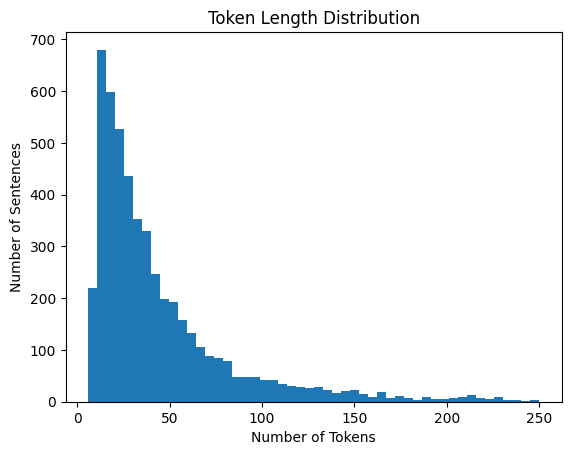

In [15]:
plt.hist(x, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Sentences")
plt.show()

In [16]:
tokens = tokenizer.tokenize("예시 문장입니다.")
print(tokens)

encoded = tokenizer("예시 문장입니다.", return_tensors="tf")
print(tokenizer.convert_ids_to_tokens(encoded['input_ids'][0]))

['예시', '문장', '##입니다', '.']
['[CLS]', '예시', '문장', '##입니다', '.', '[SEP]']


In [17]:
max_len = 150
tokenized_data = tokenizer(
    processed_sentence_list_train,
    max_length=150,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
print(tokenized_data['input_ids'].shape)        # (5044, 150)
print(tokenized_data['attention_mask'].shape)


tokenized_data_val = tokenizer(
    x_val,
    max_length=150,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
print(tokenized_data_val['input_ids'].shape)        # (5044, 150)
print(tokenized_data_val['attention_mask'].shape)


tokenized_data_test = tokenizer(
    x_test,
    max_length=150,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)
print(tokenized_data_test['input_ids'].shape)
print(tokenized_data_test['attention_mask'].shape)

(5044, 150)
(5044, 150)
(624, 150)
(624, 150)
(625, 150)
(625, 150)


In [18]:
print(encoded_label_train,'\n')
print(y_val,'\n')
print(y_test,'\n')



[0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 2, 0, 2, 1, 0, 2, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 0, 1, 2, 2, 2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 1, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 0, 0, 2, 

In [19]:
# 토크나이저의 어휘 크기 확인
vocab_size = len(tokenizer.get_vocab())
print(f"토크나이저 어휘 크기: {vocab_size}")

토크나이저 어휘 크기: 32000


In [80]:
import numpy as np
encoded_label_train = np.array(encoded_label_train)
encoded_label_val = np.array(y_val)
encoded_label_test = np.array(y_test)

print(encoded_label_train.shape, tokenized_data['input_ids'].shape)
print(encoded_label_val.shape, tokenized_data_val['input_ids'].shape)
print(encoded_label_test.shape, tokenized_data_test['input_ids'].shape)

dataset_train = tf.data.Dataset.from_tensor_slices((tokenized_data['input_ids'],encoded_label_train))
dataset_val = tf.data.Dataset.from_tensor_slices((tokenized_data_val['input_ids'],encoded_label_val))
dataset_test = tf.data.Dataset.from_tensor_slices((tokenized_data_test['input_ids'],encoded_label_test))

dataset_train = dataset_train.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)
dataset_val = dataset_val.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)

(5044,) (5044, 150)
(624,) (624, 150)
(625,) (625, 150)


In [37]:
dataset_teacher_train = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': tokenized_data['input_ids'],
        'attention_mask': tokenized_data['attention_mask']
    },
    encoded_label_train
))

dataset_teacher_val = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': tokenized_data_val['input_ids'],
        'attention_mask': tokenized_data_val['attention_mask']
    },
    encoded_label_val
))

dataset_teacher_test = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': tokenized_data_test['input_ids'],
        'attention_mask': tokenized_data_test['attention_mask']
    },
    encoded_label_test
))

dataset_teacher_train = dataset_teacher_train.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)
dataset_teacher_val = dataset_teacher_val.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)
dataset_teacher_test = dataset_teacher_test.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
model = TransformerClassifier(num_layers = 2,
                              d_model=64,
                              num_heads=2,
                              dff = 256,
                              input_vocab_size=vocab_size,
                              maximum_position_encoding=150,
                              num_classes=3,
                              rate=0.4)



In [98]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               restore_best_weights=True)

In [99]:
history = model.fit(dataset_train, epochs = 300, validation_data = dataset_val, callbacks=[early_stopping])

Epoch 1/300
158/158 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.3382 - loss: 1.6593 - val_accuracy: 0.5048 - val_loss: 0.9895
Epoch 2/300
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3982 - loss: 1.4279 - val_accuracy: 0.5096 - val_loss: 0.9836
Epoch 3/300
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4161 - loss: 1.3643 - val_accuracy: 0.5064 - val_loss: 0.9879
Epoch 4/300
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4115 - loss: 1.3647 - val_accuracy: 0.5160 - val_loss: 0.9856
Epoch 5/300
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4290 - loss: 1.3339 - val_accuracy: 0.5272 - val_loss: 0.9827
Epoch 6/300
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4183 - loss: 1.3441 - val_accuracy: 0.5160 - val_loss: 0.9867
Epoch 7/300
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4328 - loss: 1.3041 - val_accuracy: 0.5353 - val_loss: 0.9808
Epoch 8/300
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4344 - loss: 1.2761 - val_ac

In [100]:
model.evaluate(dataset_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7539 - loss: 0.6792


[0.6386137008666992, 0.77920001745224]

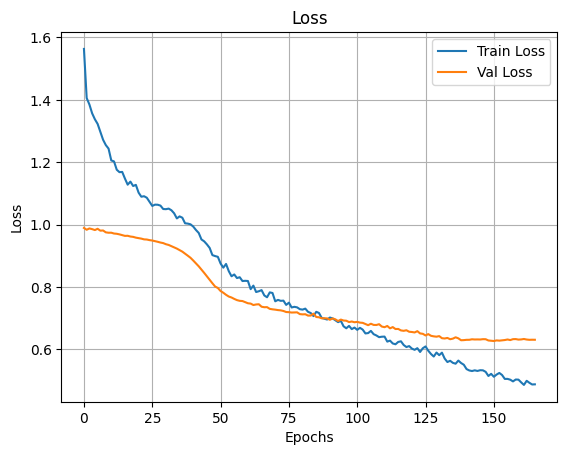

In [101]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()



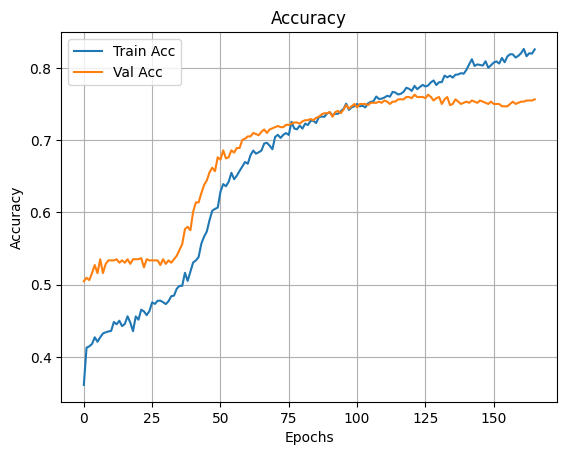

In [102]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
################################################################################################################################################################################

In [ ]:
예상 만큼 좋은 결과는 나오지 않았지만, 의미 있는 실험 결과가 나온 것 같습니다.